##Esse é um notebook que constroe um jogo da velha com Deep Reinforcement Learning.

###Instalação das bibliotecas faltantes do google colab

In [242]:
#!pip uninstall tensorflow -y
#!pip install tensorflow
#!pip uninstall keras -y
#!pip install keras
!pip install keras-rl2
#!pip install wandb #biblioteca de log

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 112kB 53.9MB/s 
     |████████████████████████████████| 460kB 50.6MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=03830839665de67345d21a249718c916a5dee1455274fac16c61a375117d2e39
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=3bca01b2aaa777a7cf60779677bc509965603114278ed8dc801ee8ff600e93fd
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=53

###Importação das bibliotecas que serão usadas durante o código.

In [0]:
import numpy as np
import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import time

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
from keras.callbacks.callbacks import LambdaCallback

###Criação da função que define o modelo de Redes Neurais Artificiais que será utilizado.

In [0]:
def cria_modelo(n_parametros, n_acoes, input_shape, janela_aprendizado, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=(janela_aprendizado,) + input_shape))

    rna.add(layers.Dense(128,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))
    
    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(32,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
    adam = optimizers.Adam()

    rna.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

    #rna.summary()

    return rna

###Criação do embiente customizado para o agente, contruido seguindo os padrões dos ambientes do Gym (biblioteca de inteligência artificial criada pela OpenAI para reinforcement learning).

In [0]:
class JogoDaVelhaEnv(gym.Env):
    def __init__(self, teste=False):
        self.campo = None
        self.n_acoes = 9
        self.n_parametros = 9
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_acoes,), dtype=np.int8)
        self.teste = teste
        self.reset()

    def observacao(self):
        obs = np.empty(self.n_acoes, dtype=np.int8)
        for i in range(self.n_acoes):
            obs[i] = self.campo[i]
        return obs

    def jogada_oponente(self):
        valido = False
        while not valido:
            jogada = np.random.choice(self.n_acoes)
            if self.campo[jogada] == 0:
                self.campo[jogada] = -1
                valido = True

    def acabou(self):

        acabou = False
        valor = 0
        
        for i in range(3):
            if self.campo[0 + (i * 3)] + self.campo[1 + (i * 3)] + self.campo[2 + (i * 3)] in [3, -3]: #confere as linhas
                valor = self.campo[0 + (i * 3)] + self.campo[1 + (i * 3)] + self.campo[2 + (i * 3)]
            if self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i] in [3, -3]: #confere as colunas
                valor = self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i]
            
        if self.campo[0] + self.campo[4] + self.campo[8] in [3, -3]:
            valor = self.campo[0] + self.campo[4] + self.campo[8]
        if self.campo[2] + self.campo[4] + self.campo[6] in [3, -3]:
            valor = self.campo[2] + self.campo[4] + self.campo[6]

        valor = int(valor / 3)
        if valor != 0:
            acabou = True
        else:
            acabou = True
            for i in range(9):
                if self.campo[i] == 0:
                    acabou = False

        return [acabou, valor]

    def step(self, acao):

        recompensa = None
        valido = None

        if self.campo[acao] == 0:
            self.campo[acao] = 1
            valido = True
            acabou = self.acabou()
            if acabou[0] and acabou[1] == 1:
                recompensa = 100
            elif acabou[0] and acabou[1] == 0:
                #recompensa = -20
                recompensa = 0
            else:
                #recompensa = 20
                recompensa = 0
        else:
            #recompensa = -10
            #valido = False
            recompensa = 0
            valido = True

        if valido and not self.acabou()[0]:
            self.jogada_oponente()
            acabou = self.acabou()
            if acabou[0]:
                recompensa = -100

        #return self.observacao(), recompensa, self.acabou()[0], {'teste':10}
        return self.observacao(), recompensa, self.acabou()[0], {}

    def reset(self):
        self.campo = np.zeros(self.n_parametros)
        comeca = bool(np.random.choice(2))
        if not self.teste and not comeca:
            self.jogada_oponente()
        return self.observacao()

    def render(self):
        #print(self.observacao())
        #time.sleep(1)
        pass

###Criação de uma política customizada para trabalhar com decaimento do epsilon.

In [0]:
from rl.policy import Policy

class MaxBoltzmannQPolicyEpsDecay(Policy):
    def __init__(self, eps=.1, tau=1., clip=(-500., 500.), n_episodios):
        super(MaxBoltzmannQPolicy, self).__init__()
        self.eps = eps
        self.tau = tau
        self.clip = clip
        self.n_episodios = n_episodios
        self.episodio = 

    def select_action(self, q_values):
        assert q_values.ndim == 1
        q_values = q_values.astype('float64')
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            exp_values = np.exp(np.clip(q_values / self.tau, self.clip[0], self.clip[1]))
            probs = exp_values / np.sum(exp_values)
            action = np.random.choice(range(nb_actions), p=probs)
        else:
            action = np.argmax(q_values)
        return action

    def get_config(self):
        config = super(MaxBoltzmannQPolicy, self).get_config()
        config['eps'] = self.eps
        config['tau'] = self.tau
        config['clip'] = self.clip
        return config

###Definição de todas as variáveis importantes do código e o treino do agente.

In [296]:
ambiente = JogoDaVelhaEnv() #cria o ambiente para o jogo
n_parametros = ambiente.n_parametros #define o numero de entradas da rede
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape
janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
n_steps = 100000

memoria = SequentialMemory(limit=10000, window_length=janela_aprendizado)
modelo = cria_modelo( 9, 9, input_shape, janela_aprendizado, 0.4 )
#politica = MaxBoltzmannQPolicy( eps=0.5, tau=1.5 ) #tau grande -> Aleatorio, tau pequeno -> Greedy
politica = EpsGreedyQPolicy( eps=0.3 )
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy() )
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
agente.compile(optimizers.Adam(), metrics=['mae', 'acc'])

historia_treino = []
batch_print_callback_treino = LambdaCallback(on_batch_end=lambda batch,logs: historia_treino.append(logs))

agente.fit(env=ambiente, nb_steps=n_steps, visualize=False, verbose=1, callbacks=[batch_print_callback_treino])

agente.save_weights('dqn.h5f', overwrite=True)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -12.2900
2518 episodes - episode_reward: -48.809 [-100.000, 100.000] - loss: 1220.450 - mae: 2.819 - acc: 0.173 - mean_q: 0.647

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -1.2800
2652 episodes - episode_reward: -4.827 [-100.000, 100.000] - loss: 1311.417 - mae: 3.035 - acc: 0.283 - mean_q: 0.781

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -0.4100
2674 episodes - episode_reward: -1.533 [-100.000, 100.000] - loss: 1305.199 - mae: 3.026 - acc: 0.307 - mean_q: 0.794

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: 2.7700
2696 episodes - episode_reward: 10.274 [-100.000, 100.000] - loss: 1327.883 - mae: 3.076 - acc: 0.337 - mean_q: 0.833

Interval 5 (40000 steps performed)
100

###Teste do agente que acabou de ser treinado.

In [297]:
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=['mae'])
agente.load_weights('dqn.h5f')

historia_teste = []
batch_print_callback_teste = LambdaCallback(on_batch_end=lambda batch,logs: historia_teste.append(logs))

agente.fit(env=ambiente, nb_steps=n_steps/10, visualize=False, verbose=1, callbacks=[batch_print_callback_teste])

#agente.save_weights('dqn_pos_teste.h5f', overwrite=True)

Training for 10000.0 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: 13.2100
done, took 87.792 seconds


###Visualização dos resultados do teste e de treino.

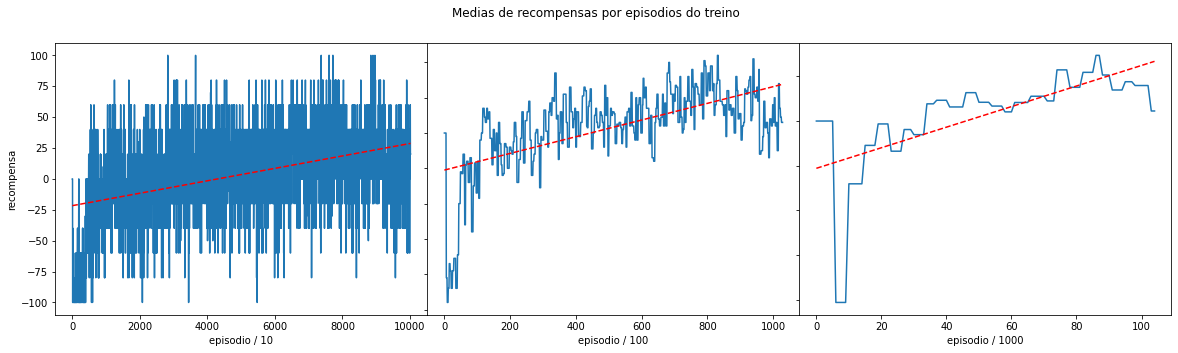

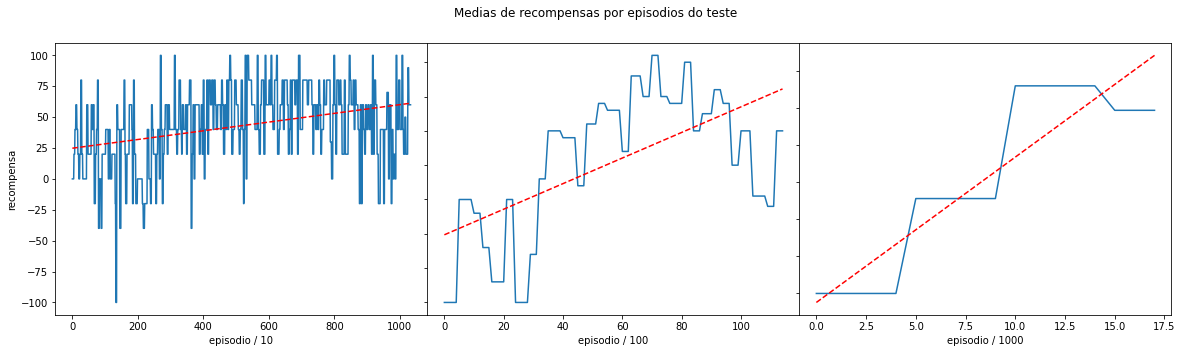

In [298]:
divisores = [10, 100, 1000]
dict_recompensas = [[historia_treino, 'treino'], [historia_teste, 'teste']]
for dict_recompensa in dict_recompensas:
    hist_recompensa = dict_recompensa[0]
    tipo = dict_recompensa[1]
    fig, axs = plt.subplots(1, 3, gridspec_kw={'wspace': 0}, figsize=(20,5))
    fig.suptitle('Medias de recompensas por episodios do {}'.format(tipo))
    axs[0].set(ylabel='recompensa')
    grafico = 0
    for divisor in divisores:
        recompensas = []
        recompensas_media = []
        recompensas_ref = []
        ref = 0
        for i in range(len(hist_recompensa) + 1):
            if len(recompensas) % divisor == 0:
                recompensas_media.append( sum(recompensas[-divisor:]) / divisor )
            if len(hist_recompensa) == i or hist_recompensa[i]['episode'] != ref:
                recompensas.append( round(sum(recompensas_ref), 1) )
                ref += 1
                recompensas_ref = []
            if len(hist_recompensa) != i:
                recompensas_ref.append( hist_recompensa[i]['reward'] )

        #plota grafico
        x_plot = np.arange(len(recompensas_media))
        axs[grafico].set(xlabel='episodio / {}'.format(divisor))
        axs[grafico].plot(x_plot, recompensas_media)
        #linha de tendencia
        z = np.polyfit(x_plot, recompensas_media, 1)
        p = np.poly1d(z)
        axs[grafico].plot(x_plot, p(x_plot),"r--")
        axs[grafico].label_outer()
        grafico += 1

        fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto

###Jogando contra o agente treinado.

In [295]:
def jogada_agente(agente, estado):
    estado_reshape = [estado]
    saida = agente.compute_q_values( estado_reshape )
    jogada = np.argmax( saida )
    return jogada

def printa_campo(estado, simbolo_jogador):
    for i in range(len(estado)):
        if( i ) % 3 == 0:
            print()
        else:
            print('| ', end='')
        simbolo_maquina = 'O'
        if simbolo_jogador == 'O':
            simbolo_maquina = 'X'
        if estado[i] == -1:
            print(simbolo_jogador + ' ', end='')
        elif estado[i] == 1:
            print(simbolo_maquina + ' ', end='')
        else:
            print('- ', end='')
    print()

#jogar contra a maquina
ambiente = JogoDaVelhaEnv( teste=True ) #cria o ambiente para o jogo
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam())
agente.load_weights('dqn.h5f')

vez_do_jogador = False

while not ambiente.acabou()[0]:
    if vez_do_jogador:
        #jogada do jogador
        jogada_valida = False
        while not jogada_valida:
            jogada = int(input('campo a jogar: '))
            if ambiente.campo[ jogada ] != 0:
                print('campo inválido')
            else:
                ambiente.campo[ jogada ] = -1
                jogada_valida = True

    else:
        #jogada da maquina
        jogada_valida = False
        contagem = 0
        while not jogada_valida:
            jogada = jogada_agente( agente, ambiente.observacao() )
            if ambiente.campo[ jogada ] == 0:
                ambiente.campo[ jogada ] = 1
                jogada_valida = True
            contagem += 1
            if contagem == 10:
                break
    
    vez_do_jogador = not vez_do_jogador
    printa_campo( ambiente.observacao(), 'X' )

resultado = ambiente.acabou()[1]
ganhador = None #define uma variavel para quem ganhou o jogo
if resultado == -1: #se o resultado for 1
    ganhador = 'Voce ganhou' #o ganhador foi a IA
elif resultado == 1: #se o resultado for -1
    ganhador = 'A IA ganhou' #o ganhador foi o oponente aleatorio
else: #se o resultado for 0
    ganhador = 'Deu velha' #o jogo deu velha

print(ganhador)


- | - | - 
- | - | - 
- | - | O 
campo a jogar: 4

- | - | - 
- | X | - 
- | - | O 

- | - | - 
- | X | - 
- | O | O 
campo a jogar: 6

- | - | - 
- | X | - 
X | O | O 

O | - | - 
- | X | - 
X | O | O 
campo a jogar: 2

O | - | X 
- | X | - 
X | O | O 
Voce ganhou


In [268]:
ambiente.reset()
ambiente.campo = [1, 0, 0, -1, -1, -1, 1, 1, -1]
result = ambiente.acabou()
print(result)

[False, 0]
